## Training a GP surrogate model

This notebook demonstrates how to train a GP model to represent the outputs of an ODE model.


In [11]:
import torch
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import pickle

%load_ext autoreload
%autoreload 2

sys.path.append("../")
from vpop_calibration.model.gp import GP
from vpop_calibration.model.ode import OdeModel
from vpop_calibration.data_generation import simulate_dataset_from_ranges

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate a training data set


In [2]:
# Define the ode model
def equations(t, y, k_12, k_21, k_el):
    ydot = [  # y[0] is A1, y[1] is A2
        k_21 * y[1] - k_12 * y[0] - k_el * y[0],
        k_12 * y[0] - k_21 * y[1],
    ]
    return ydot


variable_names = ["A0", "A1"]
parameter_names = ["k_12", "k_21", "k_el"]

pk_two_compartments_model = OdeModel(equations, variable_names, parameter_names)

In [3]:
nb_timesteps = 15
tmax = 24.0
initial_conditions = np.array([10.0, 0.0])
time_steps = np.linspace(0.0, tmax, nb_timesteps)

log_nb_patients = 5
nb_patients = 2**log_nb_patients
param_ranges = {
    "k_12": {"low": 0.02, "high": 0.07, "log": False},
    "k_21": {"low": 0.1, "high": 0.3, "log": False},
}

protocol_design = pd.DataFrame({"protocol_arm": ["A", "B"], "k_el": [0.1, 0.5]})

In [4]:
# Generate a noise-free data set
dataset = simulate_dataset_from_ranges(
    pk_two_compartments_model,
    log_nb_patients,
    param_ranges,
    initial_conditions,
    protocol_design,
    None,
    None,
    time_steps,
)

### Define and train a GP model


In [5]:
learned_ode_params = list(param_ranges.keys())
descriptors = learned_ode_params + ["time"]
print(descriptors)

# initiate our GP class
myGP = GP(
    dataset,
    descriptors,
    var_strat="IMV",  # either IMV (Independent Multitask Variational) or LMCV (Linear Model of Coregionalization Variational)
    kernel="RBF",  # Either RBF or SMK
    data_already_normalized=False,  # default
    nb_inducing_points=100,
    mll="ELBO",  # default, otherwise PLL
    nb_training_iter=200,
    training_proportion=0.7,
    learning_rate=0.1,
    lr_decay=0.99,
    jitter=1e-6,
    log_inputs=learned_ode_params,
)

['k_12', 'k_21', 'time']


/home/paul.lemarre/git/vpop-calibration/examples/../vpop_calibration/model/gp.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.Tensor(mean.loc[self.tasks]),
/home/paul.lemarre/git/vpop-calibration/examples/../vpop_calibration/model/gp.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.Tensor(std.loc[self.tasks]),


In [6]:
myGP.train()

100%|██████████| 200/200 [00:07<00:00, 28.07it/s, loss=-6.73] 


### Assess the goodness of fit of the GP


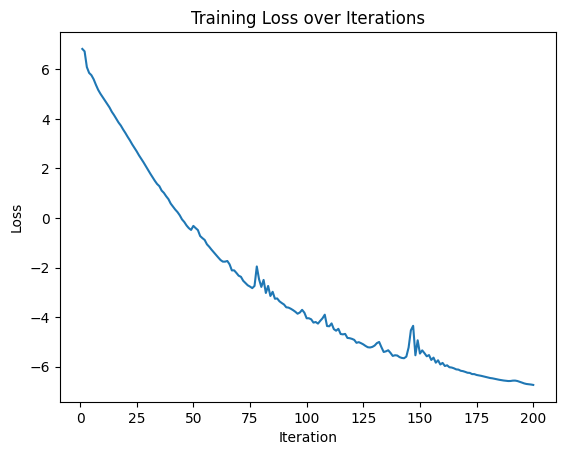

Root mean squared error on training data set (for each output x scenario):
[0.01065316397083798, 0.01677803907446195, 0.01578032614811949, 0.018860804736295884]
Root mean squared error on validation data set (for each output x scenario):
[0.01154286590894127, 0.02062259803649515, 0.01727148435244199, 0.022123875704936298]


In [7]:
myGP.plot_loss()
myGP.eval_perf()

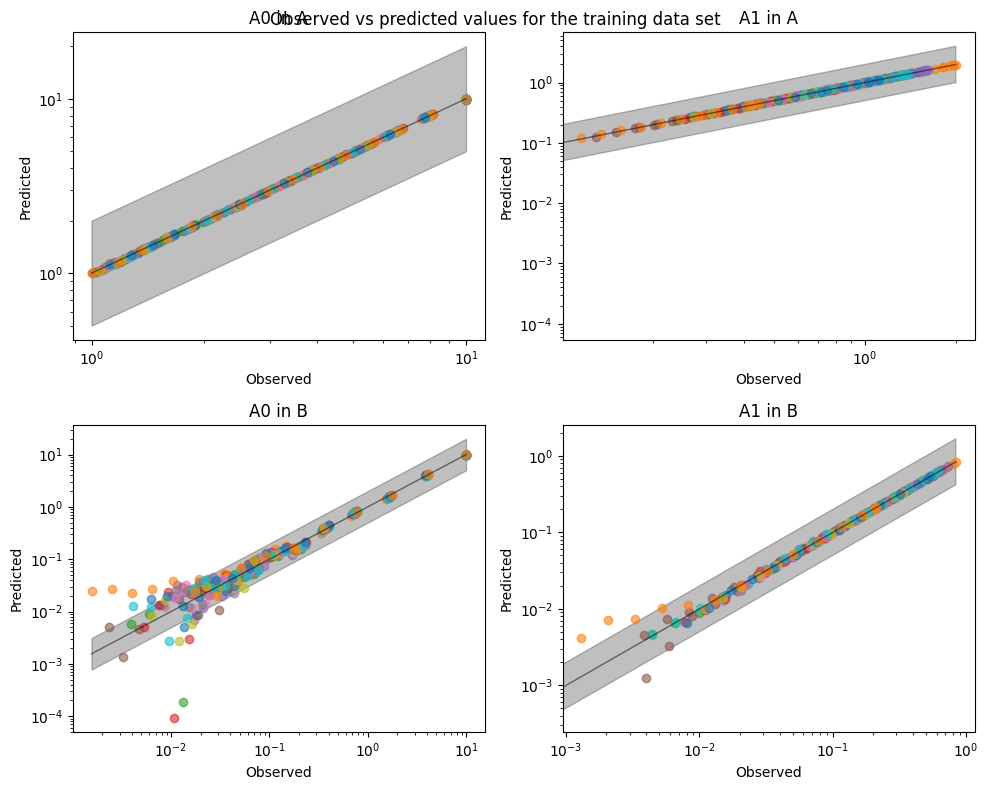

In [8]:
myGP.plot_obs_vs_predicted(data_set="training")

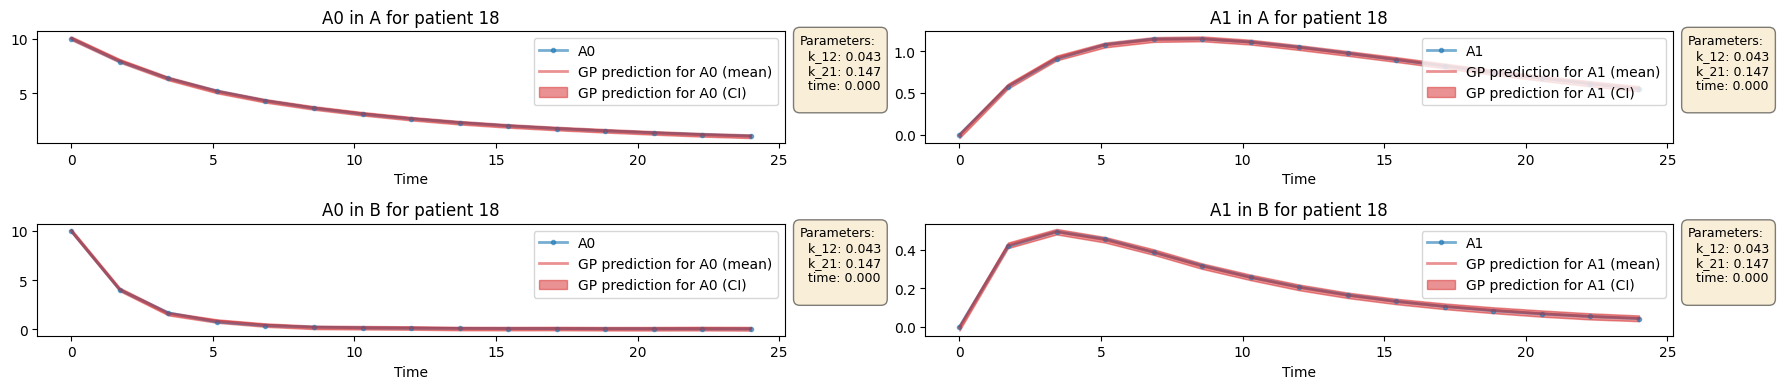

In [9]:
j = torch.randint(nb_patients, (1,))[0]
myGP.plot_individual_solution(j)

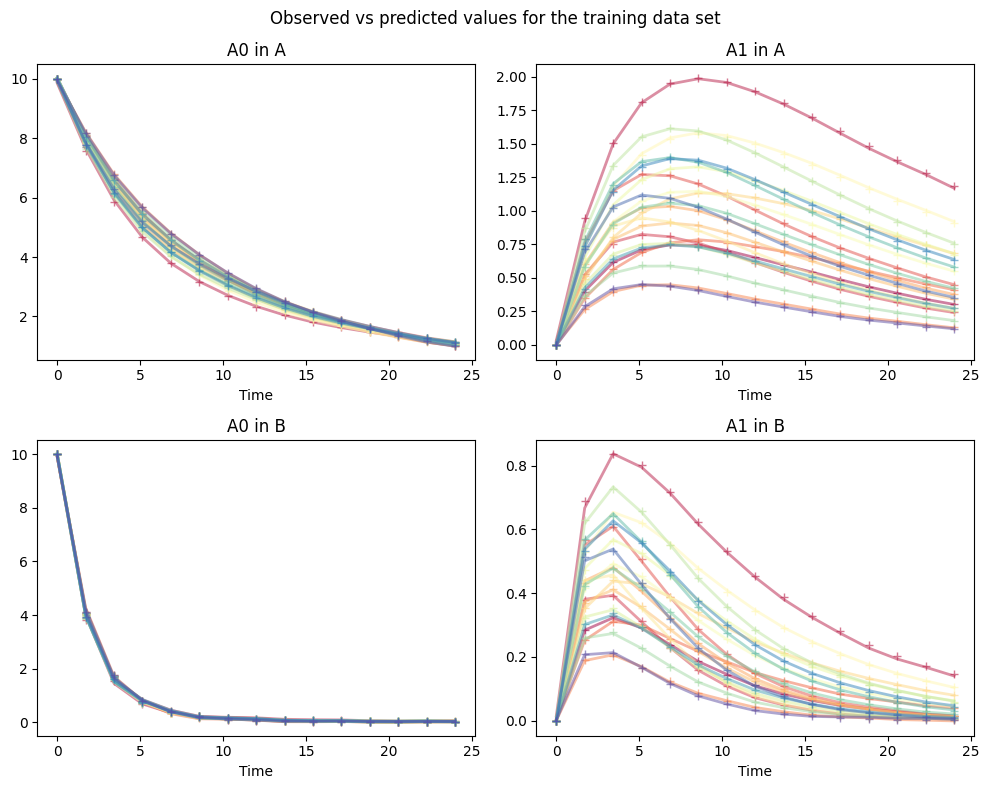

In [10]:
myGP.plot_all_solutions("training")

## Save your trained model in a pickle for later use


In [ ]:
model_file = "gp_model_example.pkl"
folder_path = "./serialized_models/"
with open(folder_path + model_file, "wb") as file:
    pickle.dump(myGP, file)
print(f"Model saved to {model_file}")

Model saved to gp_surrogate_pk_model.pkl
